In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import datetime
import calendar

from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import cvxpy as cp

import plotly.express as px
import plotly.graph_objects as go

import urllib.request
import json

#### Get S&P 500 tickers

In [5]:
# Get S&P 500 tickers from wikipedia table
wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = wiki[0]
second_table = wiki[1]

# Keep tickers that were first added before 1/1/2016 and randomly select 50
df = first_table
df_date_filter = df[df['Date first added'] < '2016-01-01'].copy()
tickers = df_date_filter.sample(n=50, random_state=3)['Symbol'].to_list()

#### Get historical ESG data

In [6]:
# Lists for saving the historical esg scores for each ticker, and missing list in case data are missing for a ticker
esg_list = []
e_list = []
s_list = []
g_list = []
missing = []

for ticker in tickers:
    # Try fetching ESG data from yahoo finance
    try:
        url = "https://query2.finance.yahoo.com/v1/finance/esgChart?symbol={}".format(ticker)

        connection = urllib.request.urlopen(url)

        data_connection = connection.read()
        data_json = json.loads(data_connection)
        formatdata = data_json["esgChart"]["result"][0]["symbolSeries"]
        df_data = pd.DataFrame(formatdata)
        df_data["timestamp"] = pd.to_datetime(df_data["timestamp"], unit="s")
        df_data = df_data.set_index('timestamp')
        # Filter to keep only years 2016 (in-sample) and 2017 (out-of-sample)
        df_data = df_data.loc['2016':'2017']
        esg_list.append(df_data['esgScore'])
        e_list.append(df_data['environmentScore'])
        s_list.append(df_data['socialScore'])
        g_list.append(df_data['governanceScore'])
    except:
        missing.append(ticker)
        continue

# If ticker is missing data remove ticker from investment sample universe
if missing != None:
    for tick in missing:
        tickers.remove(tick)

esg_df = pd.concat(esg_list, axis=1)
esg_df.columns = tickers

e_df = pd.concat(e_list, axis=1)
e_df.columns = tickers

s_df = pd.concat(s_list, axis=1)
s_df.columns = tickers

g_df = pd.concat(g_list, axis=1)
g_df.columns = tickers

<AxesSubplot:ylabel='Frequency'>

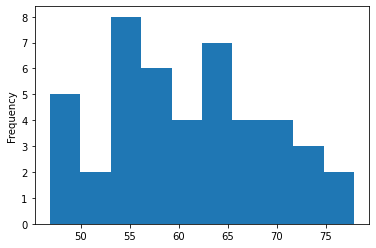

In [7]:
# Plot distribution of ESG scores for investment sample universe
esg_df.mean().plot(kind='hist')

#### Get historical stock price data

In [8]:
# Year and month that historical ESG data start
year_start = esg_df.index[0].date().year
month_start = esg_df.index[0].date().month

# Year, month and last day that ESG historical data end
year_end = esg_df.index[-1].date().year
month_end = esg_df.index[-1].date().month
last_day_date = calendar.monthrange(year_end, month_end)[1]

# First calendar day of historical data
start = datetime.date(year_start,month_start,1)
# Last calendar day of historical data
end = datetime.date(year_end,month_end,last_day_date)

data_source = 'yahoo'

# Function for fetching historical stock prices (keep close price)
def get_stocks(ticker, source, start, end):
    stocks_list = []
    for tick in ticker:
        try:
            stocks = DataReader(tick, source, start, end)
            stocks_list.append(stocks[['Close']].add_suffix('_'+tick))
        except:
            continue
    
    all_stocks = pd.concat(stocks_list, axis = 1)
    return all_stocks

# Get historical stock prices
stocks = get_stocks(tickers, data_source, start, end)
clean_ticks = list(map(lambda x: x.split('_')[1], stocks.columns))
stocks.columns = clean_ticks

In [9]:
stocks.head()

,ELV,LUMN,UNP,ALL,CMS,ADI,MTB,BXP,RHI,SBUX,...,HES,CMG,CVS,TMO,CHRW,NEM,PSX,CCL,JCI,TFC
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,139.210007,25.110001,78.970001,60.669998,35.610001,54.439999,117.480003,124.199997,46.139999,58.259998,...,48.180000,448.809998,96.459999,138.750000,61.790001,18.440001,80.080002,54.200001,33.287956,36.650002
2016-01-05,141.240005,24.990000,78.209999,60.529999,35.889999,54.040001,118.129997,127.260002,46.290001,58.650002,...,48.070000,449.029999,96.739998,138.509995,63.470001,18.420000,81.000000,53.680000,32.890053,36.660000
2016-01-06,137.789993,24.719999,74.830002,59.849998,35.939999,51.740002,115.739998,127.239998,45.060001,58.130001,...,45.070000,426.670013,95.559998,137.449997,63.160000,18.559999,78.029999,53.520000,32.575916,36.150002
2016-01-07,135.429993,24.219999,73.080002,58.439999,36.160000,50.419998,112.480003,124.980003,44.900002,56.689999,...,43.619999,416.000000,94.180000,134.309998,63.090000,18.860001,76.449997,52.389999,31.748692,35.119999
2016-01-08,132.130005,23.969999,73.860001,58.230000,36.099998,49.980000,110.169998,121.480003,43.790001,56.630001,...,43.580002,413.290009,93.559998,134.160004,63.119999,18.010000,75.209999,52.049999,31.696335,34.360001


In [10]:
esg_tot_sample = esg_df[clean_ticks].copy()
esg_e_sample = e_df[clean_ticks].copy()
esg_s_sample = s_df[clean_ticks].copy()
esg_g_sample = g_df[clean_ticks].copy()

In [11]:
# Function for optimization and computing efficient frontier
class efficient_frontier():
    def __init__(self, stocks, up_bound, samples, ticks):
        self.stocks = stocks
        self.upper_bound = up_bound
        self.samples = samples
        self.ticks = ticks
    
    # Optimization
    def optimize_portfolios(self):
        # Compute exponentially weighted historical mean returns
        mu = ema_historical_return(self.stocks)
        # Compute covariance matrix using ledoit-wolf shrinkage 
        s = CovarianceShrinkage(self.stocks).ledoit_wolf()
        n = len(mu)
        # Set upper bound for weights
        upper_bound = self.upper_bound
        w = cp.Variable(n)
        gamma = cp.Parameter(nonneg=True)
        ret = mu.to_numpy().T@w 
        risk = cp.quad_form(w, s.to_numpy())
        # Utility function to optimize
        prob = cp.Problem(cp.Maximize(ret - gamma*risk), 
                          [cp.sum(w) == 1, w >= 0, w <= upper_bound])
        
        risk_data = np.zeros(self.samples)
        ret_data = np.zeros(self.samples)
        weights_data = []
        # Gamma variables for utility function
        gamma_vals = np.logspace(-2, 3, num=self.samples)

        for i in range(self.samples):
            gamma.value = gamma_vals[i]
            prob.solve()
            weights = w
            weights_tick = pd.Series(weights.value, index=self.ticks)
            weights_tick_filter = weights_tick[weights_tick > 1.0e-03]
            weights_data.append(weights_tick_filter)
            risk_data[i] = cp.sqrt(risk).value
            ret_data[i] = ret.value
        # DataFrame with weights of stocks    
        weights_df = pd.concat(weights_data, axis = 1).T.fillna(0)
        # DataFrame with returns and risk
        rr_df = pd.DataFrame({'Return': ret_data, 'Risk': risk_data})
        self.portfolios_df = pd.concat([rr_df, weights_df], axis = 1)

In [12]:
# No Screen
conv_frontier = efficient_frontier(stocks.loc['2016'], 0.05, 200, clean_ticks)
conv_frontier.optimize_portfolios()

In [13]:
# ESG screening function
def screen(esg_df, stocks_df):
    mean_esg = esg_df.mean()
    thresh = mean_esg.quantile(0.3)
    mean_esg = mean_esg[mean_esg > thresh]
    screen_stocks = stocks_df[mean_esg.index]
    screen_ticks = screen_stocks.columns
    return screen_stocks, screen_ticks

In [14]:
# E Screen
e_stocks, e_ticks = screen(esg_e_sample, stocks.loc['2016'])
e_frontier = efficient_frontier(e_stocks, 0.05, 200, e_ticks)
e_frontier.optimize_portfolios()

# S Screen
s_stocks, s_ticks = screen(esg_s_sample, stocks.loc['2016'])
s_frontier = efficient_frontier(s_stocks, 0.05, 200, s_ticks)
s_frontier.optimize_portfolios()

# G Screen
g_stocks, g_ticks = screen(esg_g_sample, stocks.loc['2016'])
g_frontier = efficient_frontier(g_stocks, 0.05, 200, g_ticks)
g_frontier.optimize_portfolios()

# ESG Screen
esg_stocks, esg_ticks = screen(esg_tot_sample, stocks.loc['2016'])
esg_frontier = efficient_frontier(esg_stocks, 0.05, 200, esg_ticks)
esg_frontier.optimize_portfolios()

In [15]:
rr_conv = conv_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_conv['Screen'] = 'No Screen'

rr_e = e_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_e['Screen'] = 'E'

rr_s = s_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_s['Screen'] = 'S'

rr_g = g_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_g['Screen'] = 'G'

rr_esg = esg_frontier.portfolios_df[['Return', 'Risk']].copy()
rr_esg['Screen'] = 'ESG'

rr_all = pd.concat([rr_conv, rr_e, rr_s, rr_g, rr_esg])

In [16]:
# Efficient Frontier portfolios
px.scatter(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)

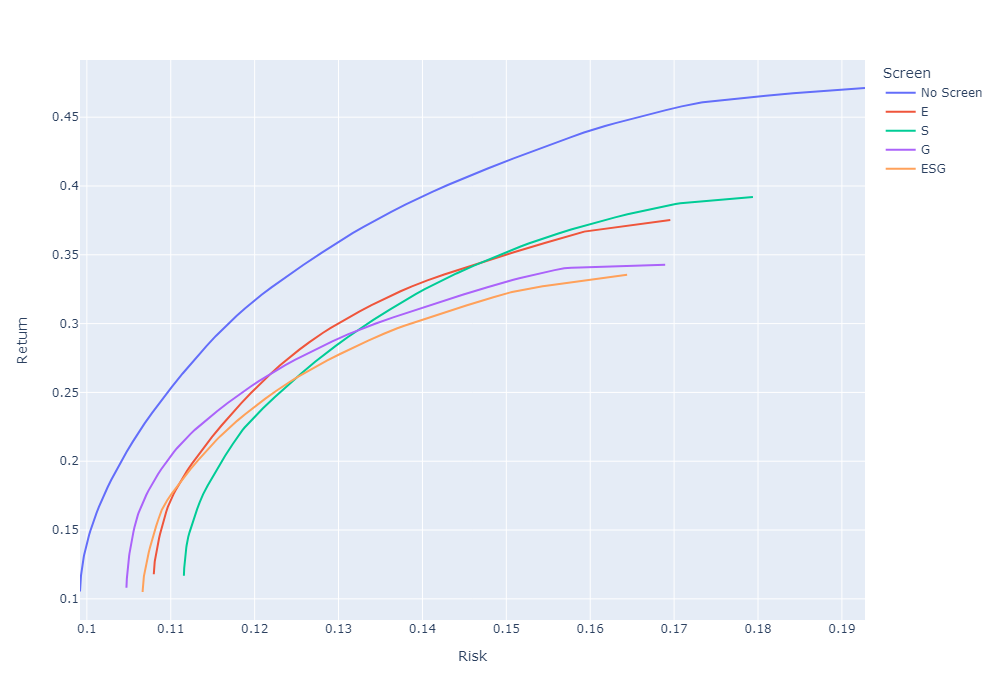

In [17]:
# Efficient Frontier Lines
fig = px.line(rr_all, x='Risk', y='Return', color='Screen', width=1000, height=700)
fig.show('png')

In [18]:
# Function to calculate returns-risk-weights of maximum sharpe ratio portfolios (using a risk-free rate of 2%)
def get_sharpe_rr_and_weights(df):
    df['Sharpe'] = (df['Return'] - 0.02) / df['Risk']
    sharpe_rr = df.iloc[df['Sharpe'].idxmax()].loc[['Return', 'Risk']]
    sharpe_weights = df.drop(['Return', 'Risk', 'Sharpe'], axis = 1).iloc[df['Sharpe'].idxmax()]
    sharpe_weights = sharpe_weights[sharpe_weights!=0]
    return sharpe_rr, sharpe_weights

In [19]:
# Compute maximum sharpe ratio portfolios
conv_sh_rr, conv_sh_w = get_sharpe_rr_and_weights(conv_frontier.portfolios_df)
e_sh_rr, e_sh_w = get_sharpe_rr_and_weights(e_frontier.portfolios_df)
s_sh_rr, s_sh_w = get_sharpe_rr_and_weights(s_frontier.portfolios_df)
g_sh_rr, g_sh_w = get_sharpe_rr_and_weights(g_frontier.portfolios_df)
esg_sh_rr, esg_sh_w = get_sharpe_rr_and_weights(esg_frontier.portfolios_df)

In [20]:
sh_rr_all = pd.concat([conv_sh_rr, e_sh_rr, s_sh_rr, g_sh_rr, esg_sh_rr], axis=1).T
sh_rr_all['Screen'] = ['No Screen', 'E', 'G', 'S', 'ESG']
sh_rr_all

,Return,Risk,Screen
118,0.400709,0.143014,No Screen
115,0.331419,0.140589,E
114,0.358184,0.152651,G
115,0.304529,0.136511,S
114,0.302837,0.139960,ESG


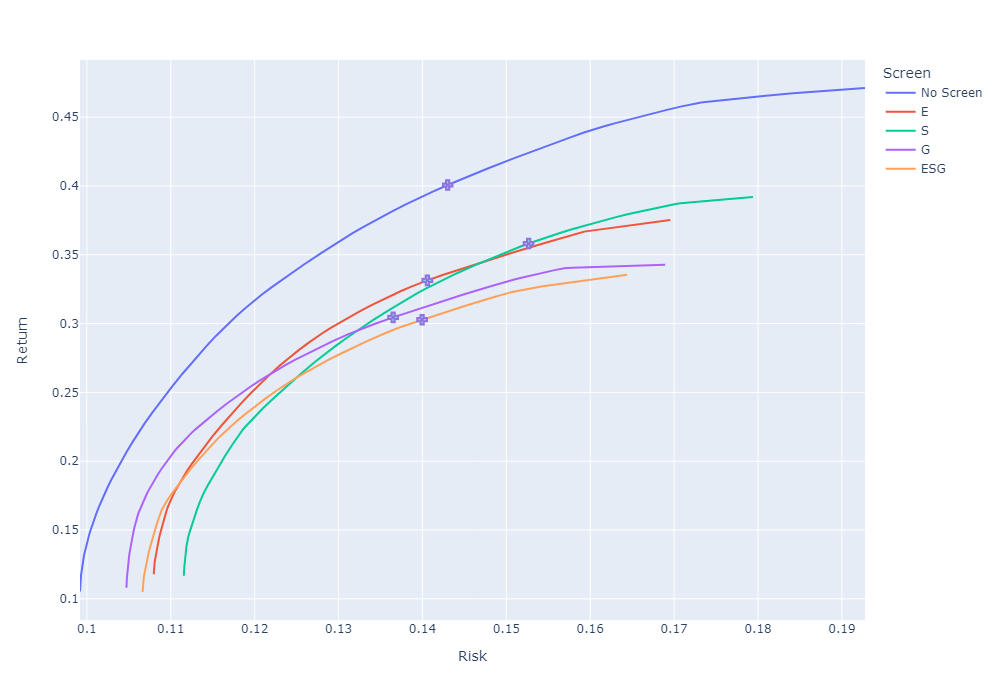

In [21]:
# Graph of Efficient Frontier with maximum sharpe ratio portfolios for each strategy
fig = px.line(rr_all, x='Risk', y='Return', color='Screen')
fig.add_trace(
    go.Scatter(
        x=sh_rr_all['Risk'],
        y=sh_rr_all['Return'],
        mode='markers',
        marker=dict(
            color='LightSkyBlue',
            size=8,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ),
        marker_symbol='cross-dot',
        showlegend=False,
    )
)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show('png')

In [22]:
# Function to compute the performance of maximum sharpe ratio portfolios
def compute_sh_portfolio(df, ticks, weights):
    stock_rets = df[ticks].pct_change().fillna(0)
    weighted_stock_rets = stock_rets * weights
    port_rets = weighted_stock_rets.sum(axis=1)
    cum_port_rets = (port_rets + 1).cumprod()
    return port_rets, cum_port_rets

In [23]:
conv_sh_rets, conv_sh_port = compute_sh_portfolio(stocks.loc['2016'], conv_sh_w.index, conv_sh_w.values)

e_sh_rets, e_sh_port = compute_sh_portfolio(stocks.loc['2016'], e_sh_w.index, e_sh_w.values)

g_sh_rets, g_sh_port = compute_sh_portfolio(stocks.loc['2016'], g_sh_w.index, g_sh_w.values)

s_sh_rets, s_sh_port = compute_sh_portfolio(stocks.loc['2016'], s_sh_w.index, s_sh_w.values)

esg_sh_rets, esg_sh_port = compute_sh_portfolio(stocks.loc['2016'], esg_sh_w.index, esg_sh_w.values)

In [24]:
all_sh_port = pd.concat([conv_sh_port,e_sh_port, s_sh_port, g_sh_port, esg_sh_port], axis = 1)
all_sh_port.columns = ['No Screen', 'E', 'S', 'G', 'ESG']
all_sh_port.head()

,No Screen,E,S,G,ESG
Date,,,,,
2016-01-04,1.000000,1.000000,1.000000,1.000000,1.000000
2016-01-05,1.001095,0.997514,0.998203,0.999109,0.997802
2016-01-06,0.983761,0.980347,0.978100,0.980769,0.978882
2016-01-07,0.962475,0.958518,0.955592,0.962037,0.957532
2016-01-08,0.951167,0.949902,0.945819,0.953120,0.949223


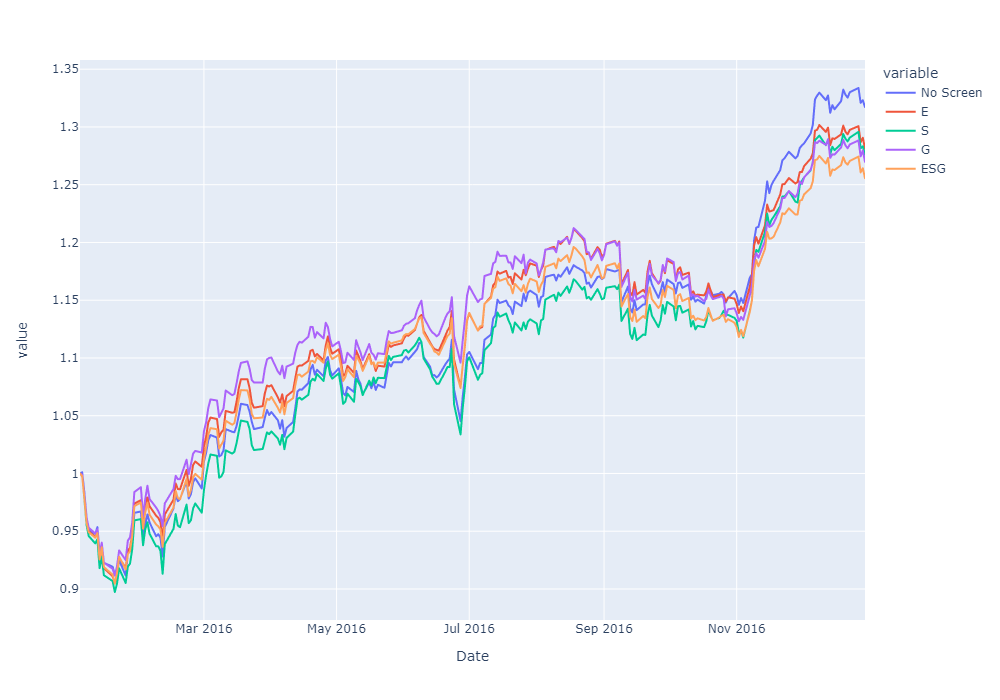

In [25]:
# In-sample performance of maximum sharpe ratio portfolios
fig = px.line(all_sh_port, x=all_sh_port.index, y=all_sh_port.columns)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show('png')

In [26]:
# Out-of-sample stock data 
stocks_oof = stocks.loc['2017'].copy()

conv_sh_rets_oof, conv_sh_port_oof = compute_sh_portfolio(stocks_oof, conv_sh_w.index, conv_sh_w.values)

e_sh_rets_oof, e_sh_port_oof = compute_sh_portfolio(stocks_oof, e_sh_w.index, e_sh_w.values)

g_sh_rets_oof, g_sh_port_oof = compute_sh_portfolio(stocks_oof, g_sh_w.index, g_sh_w.values)

s_sh_rets_oof, s_sh_port_oof = compute_sh_portfolio(stocks_oof, s_sh_w.index, s_sh_w.values)

esg_sh_rets_oof, esg_sh_port_oof = compute_sh_portfolio(stocks_oof, esg_sh_w.index, esg_sh_w.values)

all_sh_port_oof = pd.concat([conv_sh_port_oof,e_sh_port_oof, s_sh_port_oof, g_sh_port_oof, esg_sh_port_oof], axis = 1)
all_sh_port_oof.columns = ['No Screen', 'E', 'S', 'G', 'ESG']
all_sh_port_oof.head()

,No Screen,E,S,G,ESG
Date,,,,,
2017-01-03,1.000000,1.000000,1.000000,1.000000,1.000000
2017-01-04,1.006146,1.005638,1.007020,1.005673,1.005518
2017-01-05,1.002821,1.002270,1.003574,1.002289,1.003040
2017-01-06,1.005785,1.004575,1.006989,1.003300,1.004403
2017-01-09,0.999150,0.997519,0.999485,0.997143,0.997127


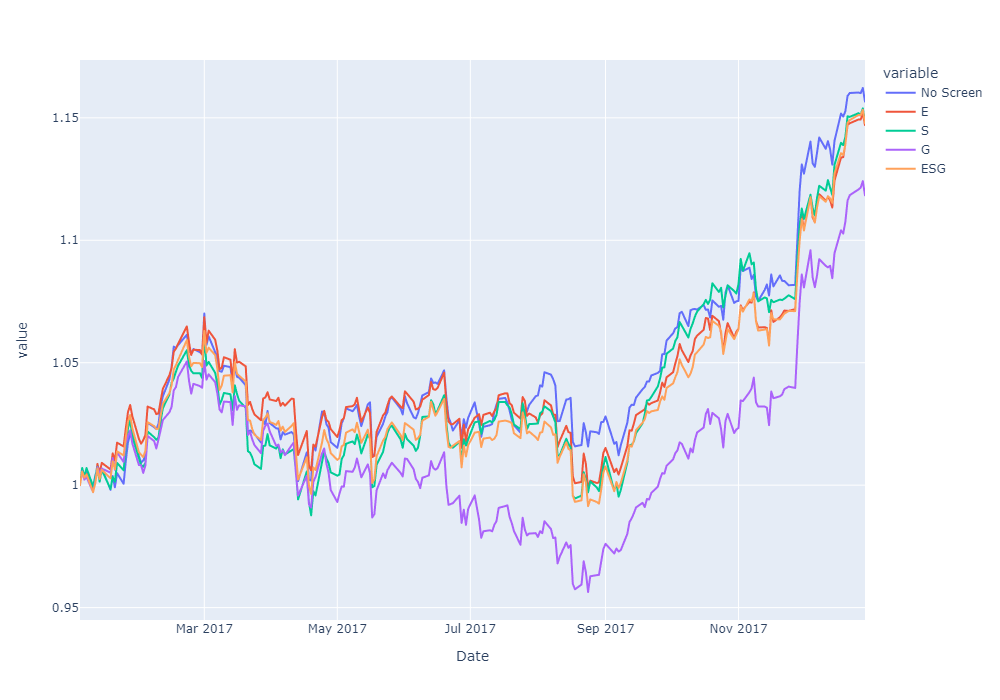

In [27]:
# Out-of-sample performance of maximum sharpe ratio portfolios
fig = px.line(all_sh_port_oof, x=all_sh_port_oof.index, y=all_sh_port_oof.columns)
fig.update_layout(
    width=1000,
    height=700,
)
fig.show('png')

#### The End :)